## Analyzing the Impact of the 2014 FIFA World Cup on Brazilian Host States

This notebook examines the economic and demographic effects of hosting the 2014 FIFA World Cup on Brazilian states. By leveraging state-level data, it evaluates whether hosting the event resulted in measurable benefits or challenges for host states. 

### Key Aspects of the Analysis

- **Objective**:  
  - Assess the economic and demographic impacts of hosting the World Cup at the state level.  
  - Determine whether hosting led to tangible benefits or incurred costs for host states.  

- **Methodology**:  
  - **Difference-in-Differences (DiD)**: Compares pre- and post-World Cup trends in host states against non-host states to identify causal effects.  

- **Focus Variables**:  
  - Population growth.  
  - Economic indicators such as GDP and Industry Level GDP.  
  - Carbon Emissions

- **Purpose**:  
  - Provide a data-driven evaluation of the trade-offs associated with hosting the World Cup.  
  - Inform future decisions on hosting large-scale international events by analyzing their economic and social ramifications.  


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns


In [2]:
population_df = pd.read_excel('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/population_data.xlsx')
population_df.head()

,SEXO,CÓD.,SIGLA,LOCAL,2000,2001,2002,2003,2004,2005,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Ambos,0,BR,Brasil,3423475,3347313,3274356,3212295,3163041,3123546,...,3012970,2948637,2883226,2920425,2885318,2777978,2688491,2597799,2527241,2484344
1,Ambos,0,BR,Brasil,3450022,3406966,3332612,3261091,3200484,3152623,...,2943154,3002376,2937001,2870232,2910089,2879163,2772134,2680031,2587620,2519770
2,Ambos,0,BR,Brasil,3461038,3444450,3401900,3327924,3256791,3196543,...,2907915,2936667,2995070,2928703,2863990,2906676,2876276,2767175,2673622,2583366
3,Ambos,0,BR,Brasil,3469109,3458052,3441638,3399284,3325501,3254582,...,2916787,2903600,2931742,2989393,2924609,2862071,2904924,2873055,2762809,2670309
4,Ambos,0,BR,Brasil,3477903,3466901,3455987,3439662,3397467,3323811,...,2898606,2913739,2900133,2927764,2986627,2923442,2861079,2902777,2869950,2760203


Population Data

In [3]:
# Define the range of years for analysis
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 
         2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 
         2020, 2021, 2022, 2023, 2024]

# List of Brazilian states for filtering the data
states = [
    "Acre", "Alagoas", "Amapá", "Amazonas", "Bahia", "Ceará",
    "Distrito Federal", "Espírito Santo", "Goiás", "Maranhão",
    "Mato Grosso", "Mato Grosso do Sul", "Minas Gerais", "Paraná",
    "Paraíba", "Pará", "Pernambuco", "Piauí", "Rio Grande do Norte",
    "Rio Grande do Sul", "Rio de Janeiro", "Rondônia", "Roraima",
    "Santa Catarina", "Sergipe", "São Paulo", "Tocantins"
]

# Group population data by 'LOCAL' (state) and sum across the specified years
population_df = population_df.groupby('LOCAL', as_index=False)[years].sum()

# Filter the dataset to include only states
population_df = population_df[population_df['LOCAL'].isin(states)]

# Calculate percentage growth in population over time for each state
# Drop the 'LOCAL' column temporarily for percentage change calculations
population_growth_df = population_df.drop('LOCAL', axis=1)

# Calculate percentage change (growth rate) across years and multiply by 100 to get percentages
population_growth_df = population_growth_df.pct_change(axis=1) * 100

# Reinsert the 'STATE' column for easier reference after calculations
population_growth_df.insert(0, "STATE", population_df['LOCAL'])

# Remove the year 2000 since percentage growth cannot be calculated for the first year
population_growth_df.drop(2000, axis=1, inplace=True)

# Reshape the DataFrame from wide to long format for better analysis and visualization
population_growth_long_df = population_growth_df.melt(id_vars=['STATE'], var_name='YEAR', value_name='Population_growth')
population_growth_long_df['YEAR'] = population_growth_long_df['YEAR'].astype(int)

population_growth_long_df.head()

,STATE,YEAR,Population_growth
0,Acre,2001,3.064908
1,Alagoas,2001,1.247077
2,Amapá,2001,4.333029
3,Amazonas,2001,2.477657
4,Bahia,2001,0.901883


State level GDP

In [4]:
gdp = pd.read_excel('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/GDP.xlsx')
gdp = gdp.rename(columns={"Unnamed: 0": "STATE"})

# Reshape the GDP DataFrame from wide to long format for better analysis and visualization
gdp_long_df = gdp.melt(id_vars=['STATE'], var_name='YEAR', value_name='GDP')
gdp_long_df['YEAR'] = gdp_long_df['YEAR'].astype(int)

gdp_long_df.head()

,STATE,YEAR,GDP
0,Rondônia,2002,7467.629889
1,Acre,2002,2971.301278
2,Amazonas,2002,22093.338008
3,Roraima,2002,2392.032670
4,Pará,2002,26482.158869


In [5]:

print(population_growth_long_df.shape)
print(gdp_long_df.shape)

(648, 3)
(567, 3)


In [6]:
print("\nMissing Values per Column:")
missing_values = population_growth_long_df.isnull().sum()
missing_values[missing_values > 0]


Missing Values per Column:


Series([], dtype: int64)

In [7]:
print("\nMissing Values per Column:")
missing_values = gdp_long_df.isnull().sum()
missing_values[missing_values > 0]


Missing Values per Column:


Series([], dtype: int64)

Industry Level Data

In [8]:
industry_level_data = pd.read_csv('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/gdp_by_industry.csv')

industry_level_data['Variável (Código)'].unique()

array([ 513,  517, 6575,  547])

In [9]:
industry_level_data = pd.read_csv('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/gdp_by_industry.csv')


# Create a mapping dictionary to translate industry codes to readable names
industry_code_mapping = {
    513: 'Agriculture',
    517: 'Industry',
    6575: 'Services',
    547: 'Electricity and Gas Supply',
}

# Map the "Variável (Código)" column to the industry names using the mapping dictionary
industry_level_data['Industry'] = industry_level_data["Variável (Código)"].map(industry_code_mapping)

# Drop unnecessary columns to clean the dataset and focus on relevant data
industry_level_data.drop([
    'Nível Territorial (Código)',   
    'Nível Territorial',           
    'Unidade de Medida (Código)',  
    'Unidade de Medida',            
    'Unidade da Federação (Código)',
    'Ano (Código)',                 
    'Variável (Código)',           
    'Variável'                     
], axis=1, inplace=True)

# Create a dictionary to translate remaining column names into English
translation_dict_columns = {
    "Valor": "GDP",                 
    "Unidade da Federação": "STATE",
    "Ano": "YEAR"                   
}

# Rename the columns using the translation dictionary
industry_level_data.rename(columns=translation_dict_columns, inplace=True)

# Display the first few rows of the cleaned and translated dataset
industry_level_data.head()

,GDP,STATE,YEAR,Industry
0,284337.00,Acre,2002,Agriculture
1,355041.00,Acre,2002,Industry
2,1071069.00,Acre,2002,Services
3,4.44,Acre,2002,Electricity and Gas Supply
4,381300.00,Acre,2003,Agriculture


In [10]:
industry_level_data['Industry'].unique()

array(['Agriculture', 'Industry', 'Services',
       'Electricity and Gas Supply'], dtype=object)

In [44]:
# Create separate DataFrames for each industry by filtering the "Industry" column.
agrigulture_df = industry_level_data[industry_level_data['Industry'] == 'Agriculture']         
industry_df = industry_level_data[industry_level_data['Industry'] == 'Industry']              
services_df = industry_level_data[industry_level_data['Industry'] == 'Services']             
electricity_gas_df = industry_level_data[industry_level_data['Industry'] == 'Electricity and Gas Supply'] 

print(agrigulture_df.shape)
print(industry_df.shape)
print(services_df.shape)
print(electricity_gas_df.shape)





(540, 4)
(540, 4)
(540, 4)
(540, 4)


Emissions Data

In [12]:
emissions = pd.read_excel('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/CO2emmissions.xlsx')

# Rename the column "Estado" to "STATE" for consistency and easier understanding
emissions.rename(columns={"Estado": "STATE"}, inplace=True)

# Define a list of years for which data will be analyzed
years = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 
         2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 
         2020, 2021, 2022, 2023]

# Group the emissions data by "STATE" and sum the values for each year
emissions_df = emissions.groupby('STATE', as_index=False)[years].sum()

# Reshape the emissions DataFrame from wide format to long format
# This makes it easier for time-series analysis and visualization
emissions_long_df = emissions_df.melt(id_vars=['STATE'], var_name='YEAR', value_name='EMISSIONS')

# Convert the "YEAR" column to integers for consistency in data types
emissions_long_df['YEAR'] = emissions_long_df['YEAR'].astype(int)

emissions_long_df.head()

,STATE,YEAR,EMISSIONS
0,Acre,2001,1.903451e+08
1,Alagoas,2001,4.801885e+07
2,Amapá,2001,-3.509315e+07
3,Amazonas,2001,-5.323357e+08
4,Bahia,2001,5.672076e+08


In [13]:
emissions_long_df.shape

(644, 3)

## Difference-in-Differences (DiD) Analysis

### Objective
The Difference-in-Differences (DiD) analysis aims to evaluate the causal impact of hosting the 2014 FIFA World Cup on key outcomes, such as GDP growth, by comparing trends in host states (treatment group) and non-host states (control group) before and after the event. 

### Methodology
1. **Groups**:
   - **Treatment Group**: States that hosted the World Cup matches (e.g., São Paulo, Rio de Janeiro, Amazonas).
   - **Control Group**: States that did not host any matches, serving as a baseline for comparison.

2. **Time Periods**:
   - **Pre-Treatment Period**: Years before 2014.
   - **Post-Treatment Period**: Years after 2014, including and beyond the treatment year.

3. **Key Variables**:
   - **Dependent Variable**: `Population Growth (%)`, `GDP` – the year-over-year percentage change in GDP.
   - **Independent Variables**:
     - `post_treatment`: A binary indicator (1 for years after 2014, 0 otherwise).
     - `treatment_group`: A binary indicator (1 for host states, 0 otherwise).
     - Interaction Term (`post_treatment * treatment_group`): Captures the differential effect of the World Cup on host states in the post-treatment period.

### Population GDP

In [14]:
host_states = [
    "São Paulo","Rio de Janeiro","Amazonas","Distrito Federal",
    "Bahia","Ceará","Pernambuco","Rio Grande do Sul",
    "Paraná","Rio Grande do Norte","Mato Grosso","Minas Gerais"    
]

non_host_states = [
    "Acre","Alagoas","Amapá",           
    "Maranhão","Mato Grosso do Sul","Espírito Santo",  
    "Goiás","Paraíba","Pará","Piauí",           
    "Rondônia","Roraima","Santa Catarina",  
    "Sergipe","Tocantins"        
]

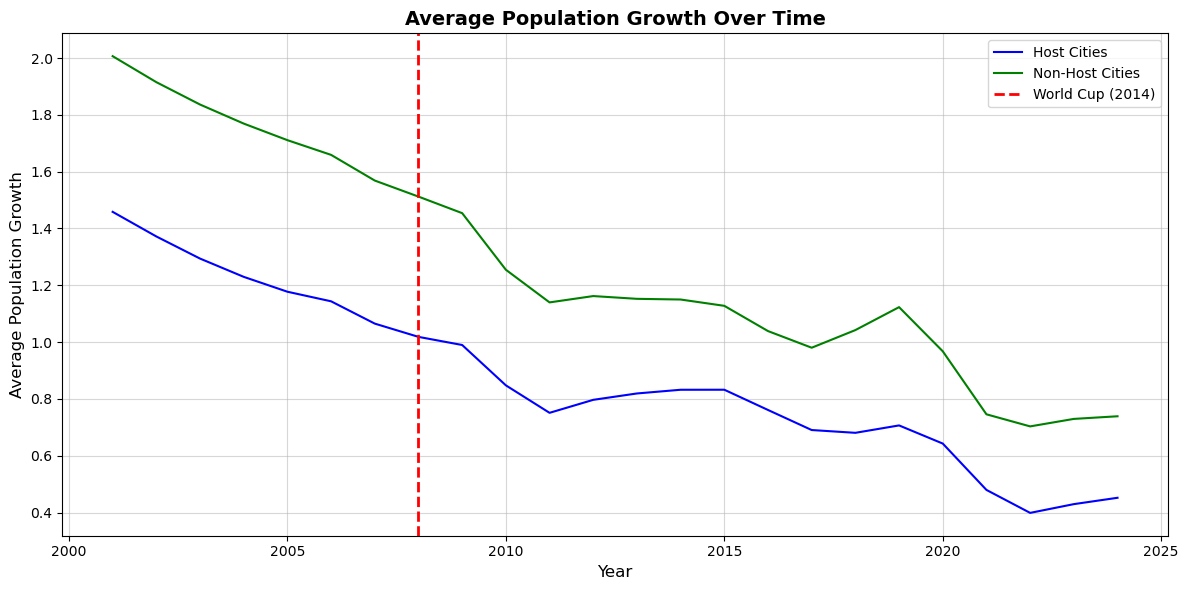

In [21]:
# Filter the data for host and non-host states
host_states_population = population_growth_long_df[population_growth_long_df['STATE'].isin(host_states)]
non_host_states_population = population_growth_long_df[population_growth_long_df['STATE'].isin(non_host_states)]

# Aggregate average population growth by year for host and non-host states
host_pop = host_states_population.groupby('YEAR')['Population_growth'].mean().reset_index()
non_host_pop = non_host_states_population.groupby('YEAR')['Population_growth'].mean().reset_index()

# Define the year of the World Cup treatment
treatment_year = 2008

# Create the plot
plt.figure(figsize=(12, 6))

# Plot population growth trends for host and non-host states
plt.plot(host_pop['YEAR'], host_pop['Population_growth'], color='blue', label='Host Cities')
plt.plot(non_host_pop['YEAR'], non_host_pop['Population_growth'], color='green', label='Non-Host Cities')

# Add vertical line for the treatment year
plt.axvline(x=treatment_year, color='red', linestyle='--', linewidth=2, label='World Cup (2014)')

# Add title, labels, and legend
plt.title('Average Population Growth Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Population Growth', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(alpha=0.5)
plt.legend(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

In [22]:
# Define the treatment year as a Pandas Period object with annual frequency
# This represents the year when the World Cup took place
world_cup_treatment = pd.Period("2008", freq="Y")

# Convert the 'YEAR' column in the DataFrame to a Pandas PeriodIndex with annual frequency
# Ensures that the 'YEAR' column is treated as a time-based index, useful for comparisons
population_growth_long_df['Year'] = pd.PeriodIndex(population_growth_long_df['YEAR'].astype(str), freq='Y')

# Create a new column 'post_treatment' indicating whether each year is after the treatment year
# Assigns 1 if the year is after 2014, and 0 otherwise
population_growth_long_df['post_treatment'] = (population_growth_long_df['Year'] > world_cup_treatment).astype(int)

# Create a new column 'treatment_group' to indicate whether each state is a host state
# Assigns 1 for host states and 0 for non-host states
population_growth_long_df['treatment_group'] = (population_growth_long_df['STATE'].isin(host_states)).astype(int)

population_growth_long_df.sample(10)


,STATE,YEAR,Population_growth,Year,post_treatment,treatment_group
45,Rio Grande do Norte,2002,1.340334,2002,0,1
492,Distrito Federal,2019,0.844922,2019,1,1
159,Sergipe,2006,1.377304,2006,0,0
542,Amapá,2021,0.679539,2021,1,0
545,Ceará,2021,0.446598,2021,1,1
298,Alagoas,2012,0.322962,2012,1,0
500,Paraíba,2019,0.733383,2019,1,0
212,Santa Catarina,2008,1.412667,2008,0,0
90,Maranhão,2004,1.175923,2004,0,0
206,Piauí,2008,0.673884,2008,0,0


In [23]:
formula = 'Population_growth ~ post_treatment + treatment_group + post_treatment*treatment_group'

model = smf.ols(formula, data=population_growth_long_df)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      Population_growth   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     65.28
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           7.26e-37
Time:                        21:37:07   Log-Likelihood:                -643.17
No. Observations:                 648   AIC:                             1294.
Df Residuals:                     644   BIC:                             1312.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### GDP DiD

In [18]:
gdp_long_df.head()

,STATE,YEAR,GDP
0,Rondônia,2002,7467.629889
1,Acre,2002,2971.301278
2,Amazonas,2002,22093.338008
3,Roraima,2002,2392.032670
4,Pará,2002,26482.158869


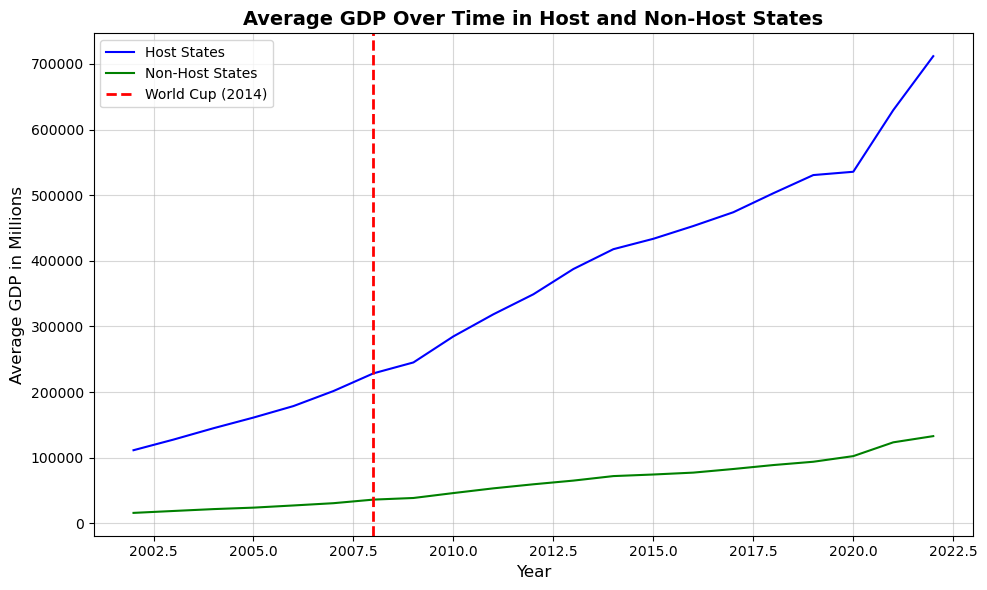

In [20]:

# Filter the data for host and non-host states
host_states_GDP = gdp_long_df[gdp_long_df['STATE'].isin(host_states)]
non_host_states_GDP = gdp_long_df[gdp_long_df['STATE'].isin(non_host_states)]

# Aggregate average GDP by year for host and non-host states
host_GDP = host_states_GDP.groupby('YEAR')['GDP'].mean().reset_index()
non_host_GDP = non_host_states_GDP.groupby('YEAR')['GDP'].mean().reset_index()

# Define the year of the World Cup treatment
treatment_year = 2008

# Create a figure for side-by-side line plots
plt.figure(figsize=(10, 6))

# Plot GDP trends for host states
plt.plot(host_GDP['YEAR'], host_GDP['GDP'], color='blue', label='Host States')

# Plot GDP trends for non-host states
plt.plot(non_host_GDP['YEAR'], non_host_GDP['GDP'], color='green', label='Non-Host States')

# Add vertical line for the World Cup year
plt.axvline(x=treatment_year, color='red', linestyle='--', linewidth=2, label='World Cup (2014)')

# Add titles and labels
plt.title('Average GDP Over Time in Host and Non-Host States', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average GDP in Millions', fontsize=12)

# Add grid and legend
plt.grid(alpha=0.5)
plt.legend(fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [24]:
# Convert the 'YEAR' column into a Pandas PeriodIndex with an annual frequency
# This ensures the 'YEAR' column is treated as time-based data, enabling proper time comparisons
gdp_long_df['Year'] = pd.PeriodIndex(gdp_long_df['YEAR'].astype(str), freq='Y')

# Create a new column 'post_treatment' to indicate whether the year is after the treatment year (2014)
# Assigns 1 if the year is after 2014 (post-treatment), and 0 otherwise
gdp_long_df['post_treatment'] = (gdp_long_df['Year'] > world_cup_treatment).astype(int)

# Create a new column 'treatment_group' to indicate whether the state is in the treatment group (host states)
# Assigns 1 for host states and 0 for non-host states
gdp_long_df['treatment_group'] = (gdp_long_df['STATE'].isin(host_states)).astype(int)


In [26]:
gdpformula = 'GDP ~ post_treatment + treatment_group + post_treatment*treatment_group'

gdpmodel = smf.ols(gdpformula, data=gdp_long_df)
results = gdpmodel.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     69.92
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           1.90e-38
Time:                        21:37:29   Log-Likelihood:                -7962.9
No. Observations:                 567   AIC:                         1.593e+04
Df Residuals:                     563   BIC:                         1.595e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## Industry level GDP DiD

In [27]:
industry_level_data.head()

,GDP,STATE,YEAR,Industry
0,284337.00,Acre,2002,Agriculture
1,355041.00,Acre,2002,Industry
2,1071069.00,Acre,2002,Services
3,4.44,Acre,2002,Electricity and Gas Supply
4,381300.00,Acre,2003,Agriculture


In [28]:
host_states_population = population_growth_long_df[population_growth_long_df['STATE'].isin(host_states)]
non_host_states_population = population_growth_long_df[population_growth_long_df['STATE'].isin(non_host_states)]

# Aggregate average population growth by year for host and non-host states
host_pop = host_states_population.groupby('YEAR')['Population_growth'].mean().reset_index()
non_host_pop = non_host_states_population.groupby('YEAR')['Population_growth'].mean().reset_index()


In [29]:
industry_df.head()

,GDP,STATE,YEAR,Industry
1,355041.0,Acre,2002,Industry
5,295101.0,Acre,2003,Industry
9,419814.0,Acre,2004,Industry
13,415902.0,Acre,2005,Industry
17,437073.0,Acre,2006,Industry


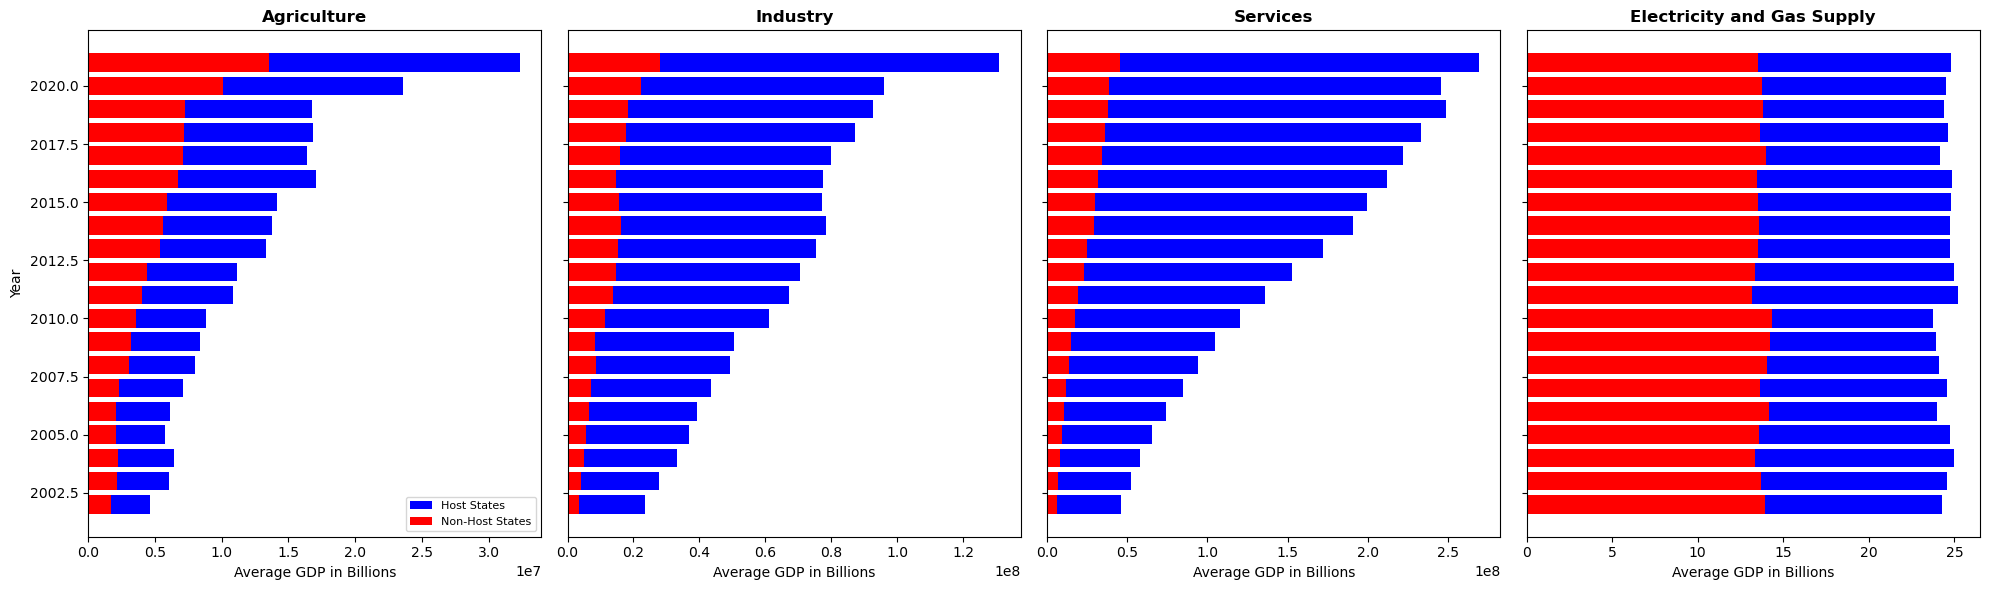

In [46]:
# List of industry-specific DataFrames
industries_df = [agrigulture_df, industry_df, services_df, electricity_gas_df]

# Get a list of unique industries
industries = industry_level_data['Industry'].unique()

# Set up subplots in a single row
fig, axes = plt.subplots(1, len(industries_df), figsize=(20, 6), sharey=True)

for idx, (industry, df) in enumerate(zip(industries, industries_df)):

    # print (industry)
    # display(industry_df)
    # Filter data for host and non-host states
    host = df[df['STATE'].isin(host_states)]
    non_host = df[df['STATE'].isin(non_host_states)]

    # Aggregate GDP by year for host and non-host states
    host_gdp = host.groupby('YEAR')['GDP'].mean().reset_index()
    non_host_gdp = non_host.groupby('YEAR')['GDP'].mean().reset_index()

    # Plot for the current industry

    
    ax = axes[idx]
    ax.barh(host_gdp['YEAR'], host_gdp['GDP'], color='blue', label='Host States')
    ax.barh(non_host_gdp['YEAR'], non_host_gdp['GDP'], color='red', label='Non-Host States')

    # Add titles and labels for each subplot
    ax.set_title(f'{industry}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Average GDP in Billions')
    if idx == 0:  # Only the first plot needs a y-axis label and legend
        ax.set_ylabel('Year')
        ax.legend(fontsize=8)
    else:
        ax.legend().remove()  # Remove legend for other plots

# Adjust layout to ensure proper spacing
plt.tight_layout()

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


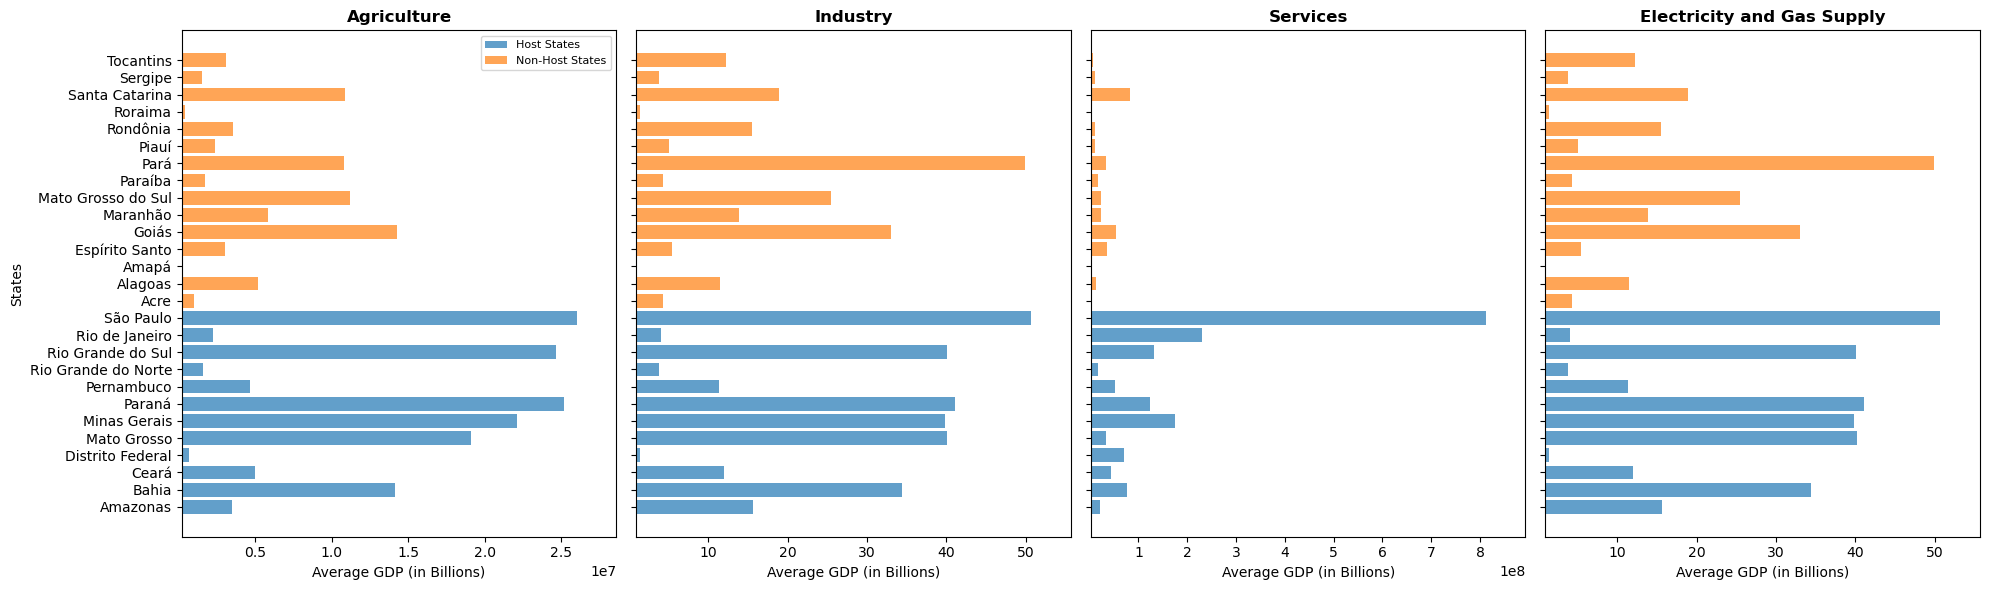

In [43]:
# Adjusting the plot to have host and non-host states on the y-axis instead of years
fig, axes = plt.subplots(1, len(industries_df), figsize=(20, 6), sharey=True)

for idx, (industry, df) in enumerate(zip(industries, industries_df)):
    # Filter data for host and non-host states
    host = df[df['STATE'].isin(host_states)]
    non_host = df[df['STATE'].isin(non_host_states)]

    # Aggregate GDP by state for host and non-host states
    host_gdp = host.groupby('STATE')['GDP'].mean().reset_index()
    non_host_gdp = non_host.groupby('STATE')['GDP'].mean().reset_index()

    # Combine data for easier plotting
    combined_gdp = pd.concat([host_gdp.assign(Group='Host States'), non_host_gdp.assign(Group='Non-Host States')])

    # Plot for the current industry
    ax = axes[idx]
    for group, data in combined_gdp.groupby('Group'):
        ax.barh(data['STATE'], data['GDP'], label=group if idx == 0 else "", alpha=0.7)

    # Adjust x-axis limits dynamically based on GDP range
    gdp_min = combined_gdp['GDP'].min()
    gdp_max = combined_gdp['GDP'].max()
    ax.set_xlim(gdp_min * 0.9, gdp_max * 1.1)  # Add some padding for better visualization

    # Add titles and labels for each subplot
    ax.set_title(f'{industry}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Average GDP (in Billions)')
    if idx == 0:  # Only the first plot needs a y-axis label and legend
        ax.set_ylabel('States')
        ax.legend(fontsize=8)
    else:
        ax.legend().remove()  # Remove legend for other plots

# Adjust layout to ensure proper spacing
plt.tight_layout()

# Show the plot
plt.show()


In [35]:
world_cup_treatment

Period('2008', 'Y-DEC')

In [45]:
industries = [agrigulture_df, industry_df, services_df, electricity_gas_df]

models = []

for industry_data in industries:
    # Add a 'Year' column as a PeriodIndex for time-series analysis
    industry_data['Year'] = pd.PeriodIndex(industry_data['YEAR'].astype(str), freq='Y')

    # Create a 'post_treatment' variable indicating whether the observation is after the World Cup
    industry_data['post_treatment'] = (industry_data['Year'] > world_cup_treatment).astype(int)

    # Create a 'treatment_group' variable indicating whether the observation is in a host state
    industry_data['treatment_group'] = (industry_data['STATE'].isin(host_states)).astype(int)

    # Define the formula for the Difference-in-Differences model
    formula = 'GDP ~ post_treatment + treatment_group + post_treatment:treatment_group'

    # Fit an Ordinary Least Squares (OLS) regression model using statsmodels
    model = smf.ols(formula, data=industry_data).fit(cov_type='HC3')

    # Store the model and the corresponding industry name in the models list
    models.append({
        "industry": industry_data['Industry'].iloc[0],  # Get the industry name
        "model": model  # Store the fitted model
    })

# Display summary for each model
for item in models:
    print(f"Industry: {item['industry']}")
    print(item['model'].summary())

Industry: Agriculture
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     63.62
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           3.37e-35
Time:                        21:41:17   Log-Likelihood:                -9444.6
No. Observations:                 540   AIC:                         1.890e+04
Df Residuals:                     536   BIC:                         1.891e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_10875/3399734054.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_data['Year'] = pd.PeriodIndex(industry_data['YEAR'].astype(str), freq='Y')
/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_10875/3399734054.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_data['post_treatment'] = (industry_data['Year'] > world_cup_treatment).astype(int)
/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_10875/3399734054.py:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


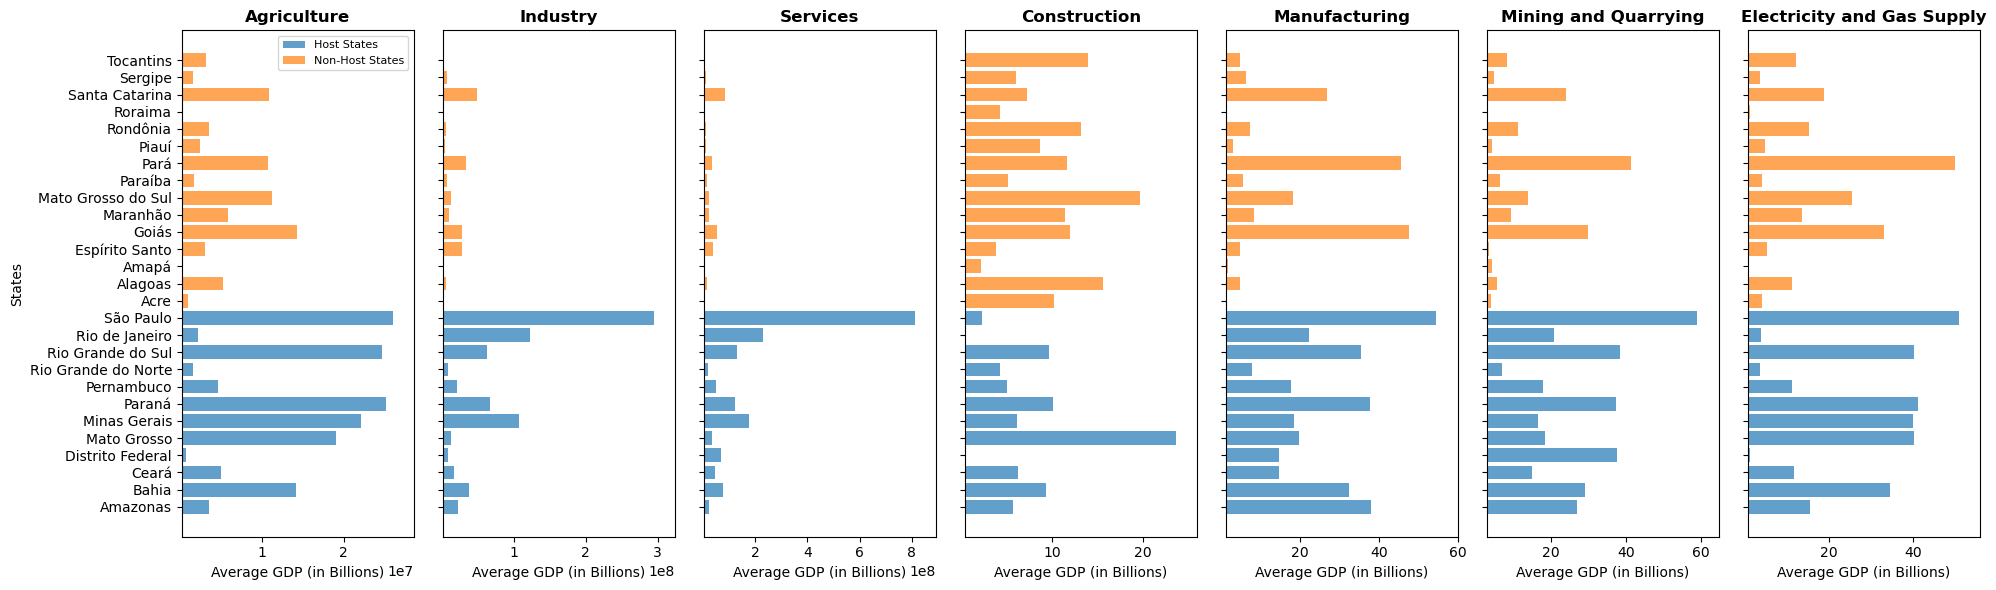

### Carbon Emissions DiD

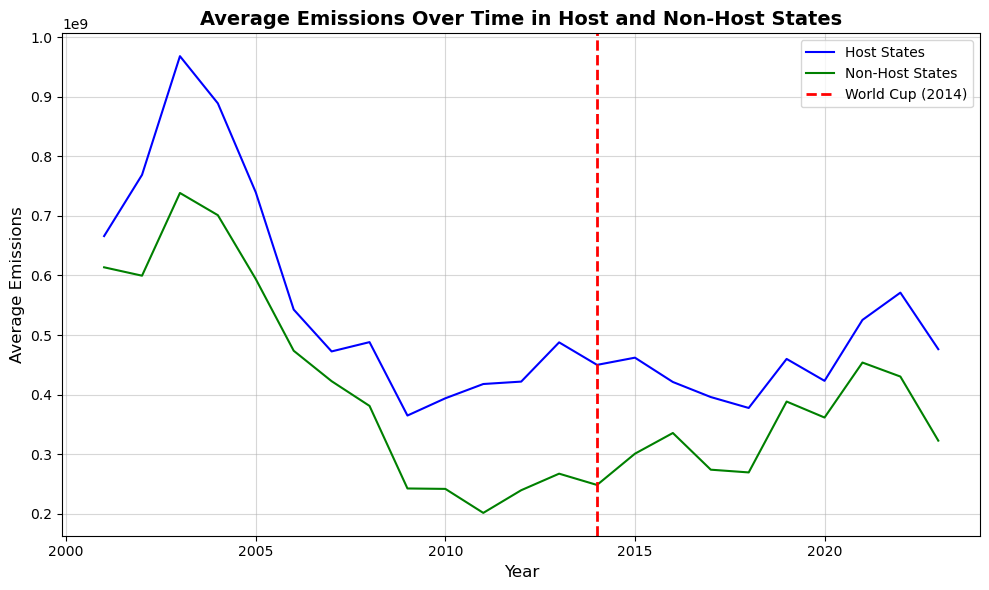

In [169]:
# Filter the data for host and non-host states
host_states_emissions = emissions_long_df[emissions_long_df['STATE'].isin(host_states)]
non_host_states_emissions = emissions_long_df[emissions_long_df['STATE'].isin(non_host_states)]

# Aggregate average emissions by year for host and non-host states
host_emissions = host_states_emissions.groupby('YEAR')['EMISSIONS'].mean().reset_index()
non_host_emissions = non_host_states_emissions.groupby('YEAR')['EMISSIONS'].mean().reset_index()

# Define the year of the World Cup treatment
treatment_year = 2014

# Create the plot
plt.figure(figsize=(10, 6))

# Plot emissions trends for host states
plt.plot(host_emissions['YEAR'], host_emissions['EMISSIONS'], color='blue', label='Host States')

# Plot emissions trends for non-host states
plt.plot(non_host_emissions['YEAR'], non_host_emissions['EMISSIONS'], color='green', label='Non-Host States')

# Add vertical line for the World Cup year
plt.axvline(x=treatment_year, color='red', linestyle='--', linewidth=2, label='World Cup (2014)')

# Add titles and labels
plt.title('Average Emissions Over Time in Host and Non-Host States', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Emissions', fontsize=12)

# Add grid and legend
plt.grid(alpha=0.5)
plt.legend(fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()



In [54]:
emissions_long_df.head()

,STATE,YEAR,EMISSIONS
0,Acre,2001,1.903451e+08
1,Alagoas,2001,4.801885e+07
2,Amapá,2001,-3.509315e+07
3,Amazonas,2001,-5.323357e+08
4,Bahia,2001,5.672076e+08


In [56]:
emissions_long_df['Year'] = pd.PeriodIndex(emissions_long_df['YEAR'].astype(str), freq='Y')

    # Create a 'post_treatment' variable indicating whether the observation is after the World Cup
emissions_long_df['post_treatment'] = (emissions_long_df['Year'] > world_cup_treatment).astype(int)

    # Create a 'treatment_group' variable indicating whether the observation is in a host state
emissions_long_df['treatment_group'] = (emissions_long_df['STATE'].isin(host_states)).astype(int)

    # Define the formula for the Difference-in-Differences model
formula = 'EMISSIONS ~ post_treatment + treatment_group + post_treatment:treatment_group'

    # Fit an Ordinary Least Squares (OLS) regression model using statsmodels
model = smf.ols(formula, data=emissions_long_df).fit(cov_type='HC3')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              EMISSIONS   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.951
Date:                Sun, 01 Dec 2024   Prob (F-statistic):              0.120
Time:                        16:14:10   Log-Likelihood:                -14076.
No. Observations:                 644   AIC:                         2.816e+04
Df Residuals:                     640   BIC:                         2.818e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   